In [3]:
# https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55
# https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/

In [2]:
!wget --header="Host: raw.githubusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.67 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" "https://raw.githubusercontent.com/1297rohit/RCNN/master/Images.zip" -c -O 'Images.zip'
!wget --header="Host: raw.githubusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.67 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" "https://raw.githubusercontent.com/1297rohit/RCNN/master/Airplanes_Annotations.zip" -c -O 'Airplanes_Annotations.zip'

--2020-12-03 04:33:15--  https://raw.githubusercontent.com/1297rohit/RCNN/master/Images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12680736 (12M) [application/zip]
Saving to: ‘Images.zip’

Images.zip          100%[===================>]  12.09M  --.-KB/s    in 0.08s   

2020-12-03 04:33:15 (155 MB/s) - ‘Images.zip’ saved [12680736/12680736]

--2020-12-03 04:33:15--  https://raw.githubusercontent.com/1297rohit/RCNN/master/Airplanes_Annotations.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181072 (177K) [application/zip]
Saving 

In [4]:
!unzip --nq Airplanes_Annotations.zip
!unzip -nq Images.zip

In [5]:
import os
import cv2
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [6]:
image_path = "Images"
annotations = "Airplanes_Annotations"

filename : airplane_278.jpg
Annotation File Name : airplane_278.csv


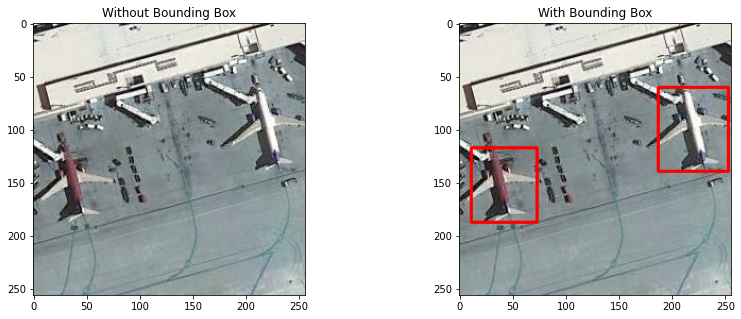

filename : airplane_443.jpg
Annotation File Name : airplane_443.csv


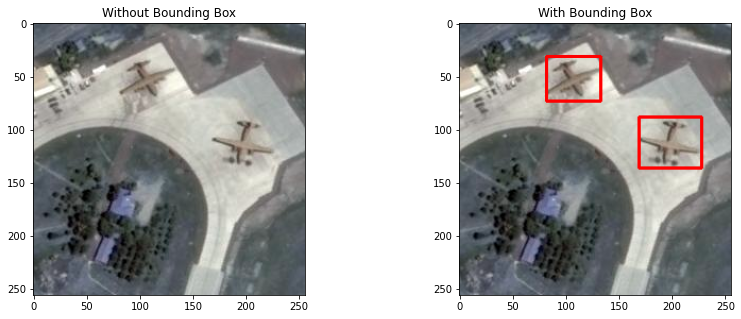

In [14]:
all_files = os.listdir(annotations)
show_files = list(map(all_files.__getitem__ , [100,444]))
for e,i in enumerate(show_files):
  filename = i.split(".")[0]+".jpg"
  print('filename :',filename)
  print('Annotation File Name :',i)
  img = cv2.imread(os.path.join(image_path,filename))
  df = pd.read_csv(os.path.join(annotations,i))
  
  f,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
  ax[0].title.set_text("Without Bounding Box")
  ax[0].imshow(img)

  for row in df.iterrows():
      x1 = int(row[1][0].split(" ")[0])
      y1 = int(row[1][0].split(" ")[1])
      x2 = int(row[1][0].split(" ")[2])
      y2 = int(row[1][0].split(" ")[3])
      cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)

  ax[1].title.set_text("With Bounding Box")
  ax[1].imshow(img)
  plt.show()
      


In [15]:
cv2.setUseOptimized(True) ## it slows the execution a bit , but provides better results.
## Read more about this at https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_core/py_optimization/py_optimization.html#default-optimization-in-opencv
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

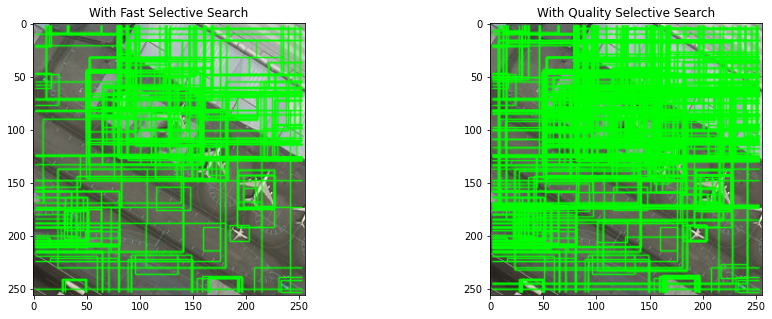

In [20]:
sample_image = 'Images/42849.jpg'

im = cv2.imread(sample_image)
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

ax[0].title.set_text("With Fast Selective Search")
ax[0].imshow(imOut)
# ax[1].show()

ss.switchToSelectiveSearchQuality()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

ax[1].title.set_text("With Quality Selective Search")
ax[1].imshow(imOut)
plt.show()

In [21]:
train_images=[]
train_labels=[]

In [22]:
## checking IOU Score

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [23]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

0 airplane_527.csv



Total Detected Box 27  with IOU greater than 0.7
1 airplane_443.csv



Total Detected Box 9  with IOU greater than 0.7
2 airplane_278.csv



Total Detected Box 1  with IOU greater than 0.7
3 airplane_496.csv



Total Detected Box 1  with IOU greater than 0.7
4 airplane_475.csv



Total Detected Box 5  with IOU greater than 0.7


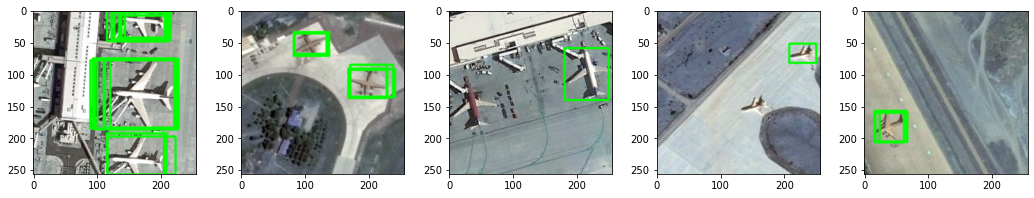

In [64]:
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

all_files = os.listdir(annotations)
images = [200,444,100,15,55]
show_files = list(map(all_files.__getitem__ , images))

fig,ax = plt.subplots(nrows=1,ncols=len(images),figsize=(18,3))


for e,i in enumerate(show_files):
  print(e,i)
  filename = i.split(".")[0]+".jpg"
  image = cv2.imread(os.path.join(image_path,filename))
  df = pd.read_csv(os.path.join(annotations,i))
  gtvalues=[] ## ground Truths

  for row in df.iterrows():
      x1 = int(row[1][0].split(" ")[0])
      y1 = int(row[1][0].split(" ")[1])
      x2 = int(row[1][0].split(" ")[2])
      y2 = int(row[1][0].split(" ")[3])
      gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
      
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  ssresults = ss.process()

  im_copy = image.copy()

  iou_list = []

  for _ ,result in tqdm(enumerate(ssresults)):
    for gtval in gtvalues:
      x,y,w,h = result
      iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
      
      if iou > 0.7:
        iou_list.append((iou,(x,y,w,h)))
  
  iou_list_sorted = sorted(iou_list,key=lambda x:x[0],reverse=True)

  for score,bbox in iou_list_sorted:
    cv2.rectangle(im_copy,(bbox[0],bbox[1]),(bbox[0]+bbox[2],bbox[1]+bbox[3]),(0,255,0),2,cv2.LINE_AA)

  ax[e].imshow(im_copy)
  print('Total Detected Box',len(iou_list)," with IOU greater than 0.7")

  # break
plt.show()

In [65]:
all_files = os.listdir(annotations)

for e,i in tqdm(enumerate(all_files),total=len(all_files)):
  try:
    filename = i.split(".")[0]+".jpg"
    image = cv2.imread(os.path.join(image_path,filename))
    df = pd.read_csv(os.path.join(annotations,i))
    gtvalues=[] ## ground Truth

    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})

    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()

    imout = image.copy()
    
    counter = 0
    falsecounter = 0
    flag = 0
    fflag = 0
    bflag = 0

    for e, result in enumerate(ssresults):
      if e < 2000 and flag == 0:
        for gtval in gtvalues:
          x,y,w,h = result
          iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
          if counter < 20:
            if iou > 0.70:
              timage = imout[y:y+h,x:x+w]
              resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
              train_images.append(resized)
              train_labels.append(1)
              counter += 1
          else :
            fflag =1

          if falsecounter < 20:
            if iou < 0.20:
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                train_images.append(resized)
                train_labels.append(0)
                falsecounter += 1
          else :
              bflag = 1

          if fflag == 1 and bflag == 1:
              flag = 1

  except Exception as e:
      print(e)
      print("error in "+filename)
      continue

In [66]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [68]:
train_images.shape, train_labels.shape

((23023, 224, 224, 3), (23023,))

In [69]:
from sklearn.model_selection import train_test_split , StratifiedShuffleSplit

x_train,x_test,y_train,y_test = train_test_split(train_images,train_labels,test_size=0.15,shuffle=True, random_state=7,stratify=train_labels)

In [70]:
x_train.shape , x_test.shape

((19569, 224, 224, 3), (3454, 224, 224, 3))

In [71]:
np.save("y_train.npy",y_train)

In [72]:
np.save("x_train.npy",x_train)
np.save("y_test.npy",y_test)
np.save("x_test.npy",x_test)

In [73]:
!zip data.zip x_train.npy y_train.npy x_test.npy y_test.npy

  adding: x_train.npy (deflated 82%)
  adding: y_train.npy (deflated 96%)
  adding: x_test.npy (deflated 81%)
  adding: y_test.npy (deflated 96%)


In [75]:
!mkdir 'drive/MyDrive/RCNN_data/'
!cp data.zip 'drive/MyDrive/RCNN_data/data.zip'

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
import gc
gc.collect()

20763

In [2]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from sklearn.model_selection import train_test_split , StratifiedShuffleSplit
from tqdm.notebook import tqdm
import os
import cv2
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gc

In [3]:
# !cp -r "drive/MyDrive/RCNN_data/data.zip" data.zip

In [4]:
x_train = np.load('x_train.npy',)
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

gc.collect()

23

In [8]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x_train,y_train,test_size=0.2,shuffle=True, random_state=7,stratify=y_train)

In [14]:
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False,)
base_model.trainable = False

input = Input(shape=(224,224,3,))
output = base_model(input)
output = GlobalMaxPooling2D()(output)
output = Dense(2,activation='softmax')(output)

model = Model(input,output)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 20,025,410
Trainable params: 1,026
Non-trainable params: 20,024,384
_________________________________________________________________


In [15]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    rotation_range = 45,
    rescale = 1./255,
    zoom_range=0.1,
    shear_range=0.1,
    validation_split = 0.2
)

In [16]:
import gc

class data_generator(tf.keras.utils.Sequence):
  def __init__(self,X,y,batch_size=16,type_="training",num_classes=2):
    
    self.type_ = type_
    self.X = X
    if self.type_ in ["training",'validation']:
      self.y = y
    else:
      self.y = None

    self.batch_size = batch_size
    self.num_classes = num_classes

    gc.collect()
  
  def __len__(self):
    return self.X.shape[0] // self.batch_size 

  def __getitem__(self,idx):
    X = self.X[idx*self.batch_size : (idx+1)*self.batch_size]
    
    if not self.y is None:
      y = self.y[idx*self.batch_size : (idx+1)*self.batch_size]
      y = tf.keras.utils.to_categorical(y,num_classes=self.num_classes)
      X,y = generator.flow(X,y,batch_size=128).__next__()
      
      return X,y
    else:

      return X

In [17]:
training = data_generator(train_x,train_y,type_="training")
validation = data_generator(test_x,test_y,type_="validation")

In [18]:
from keras import backend as K

def f1_weighted(true, pred): 

    ground_positives = K.sum(true, axis=0)       # = TP + FN
    pred_positives = K.sum(pred, axis=0)         # = TP + FP
    true_positives = K.sum(true * pred, axis=0)  # = TP

    precision = (true_positives + K.epsilon()) / (pred_positives + K.epsilon()) 
    recall = (true_positives + K.epsilon()) / (ground_positives + K.epsilon()) 

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives)
    weighted_f1 = K.sum(weighted_f1)

    return weighted_f1 #for metrics, return only 'weighted_f1'

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['acc',
                       f1_weighted
                       ])
model.fit(training,
          validation_data=validation,
          epochs=15,
          verbose=1,
          shuffle=True,
          # callbacks=[tf.keras.callbacks.ReduceLROnPlateau()]
          )

Epoch 1/15
978/978 [==============================] - 215s 220ms/step - loss: 0.4126 - acc: 0.8151 - f1_weighted: 0.7258 - val_loss: 0.3539 - val_acc: 0.8399 - val_f1_weighted: 0.7684
Epoch 2/15
978/978 [==============================] - 216s 221ms/step - loss: 0.3409 - acc: 0.8534 - f1_weighted: 0.7758 - val_loss: 0.3225 - val_acc: 0.8555 - val_f1_weighted: 0.7856
Epoch 3/15
978/978 [==============================] - 214s 219ms/step - loss: 0.3156 - acc: 0.8698 - f1_weighted: 0.7954 - val_loss: 0.3108 - val_acc: 0.8817 - val_f1_weighted: 0.7974
Epoch 4/15
978/978 [==============================] - 213s 218ms/step - loss: 0.3045 - acc: 0.8768 - f1_weighted: 0.8054 - val_loss: 0.3062 - val_acc: 0.8648 - val_f1_weighted: 0.8065
Epoch 5/15
978/978 [==============================] - 214s 219ms/step - loss: 0.2941 - acc: 0.8795 - f1_weighted: 0.8134 - val_loss: 0.3004 - val_acc: 0.8863 - val_f1_weighted: 0.8144
Epoch 6/15
978/978 [==============================] - 213s 218ms/step - loss: 0.

In [19]:
model.save("model.h5")

In [23]:
test_gen = data_generator(x_test,y_test)
model.evaluate(test_gen)

215/215 [==============================] - 40s 187ms/step - loss: 0.2630 - acc: 0.8930 - f1_weighted: 0.8386


[0.26298007369041443, 0.8930232524871826, 0.8385560512542725]

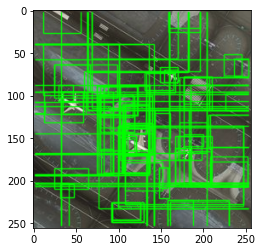

In [49]:
z=0
# for e,i in enumerate(os.listdir(path)):
  # if i.startswith("4"):
z += 1
final_predictions = []
img = cv2.imread("/content/Images/428491.jpg")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img_resized = np.expand_dims(resized, axis=0)
        out= model.predict(img_resized)
        final_predictions.append([*out[0],x,y,w,h])
        if out[0][1] > 0.99:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)
# break


In [50]:
# !cp model.h5 "/content/drive/MyDrive/RCNN_data/model.h5"

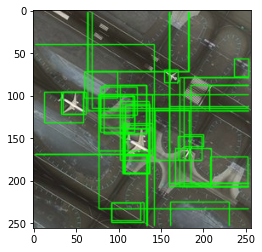

In [75]:
# sorted(final_predictions,key=lambda x:x[0][1],reverse=True)
import pandas as pd
d = pd.DataFrame(final_predictions,columns=['pred_0','pred_1','x','y','w','h'])

d = d[d['pred_0'] == 0].sort_values('pred_0',ascending=True)

im_copy = img.copy()

for i,row in d.iterrows():
  cv2.rectangle(im_copy, (int(row['x']), int(row['y'])) , (int(row['x'])+int(row['w']), int(row['y'])+int(row['h'])), (0, 255, 0), 1, cv2.LINE_AA)
  # break

plt.figure()
plt.imshow(im_copy)